In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
plot_path = "plots/redundancy_comparison.pdf"
save_plot = False

save_paths_bert =  {"random": "results/bert_4-17_random.pickle", "ours": "results/bert_4-17.pickle"}
save_paths_resnet =  {"random": "results/resnet_4-17_random.pickle", "ours": "results/resnet_4-17.pickle"}

In [3]:
def compare(res1, res2, k=5):
    #only select interactions with nonzero strengths
    inter1 = [x for x, s in res1[:k] if s>0] 
    inter2 = [x for x, s in res2[:k] if s>0]
    
    # if the two context counts settings have different number 
    # of nonzero interactions after threshold, return early because this
    # compliates the fraction overlap computation
    if(len(inter1) != len(inter2)):    
        return -1
    
    # assigns each unique interaction a unique ID
    inter_map = {}
    for x in inter1 + inter2:
        if x not in inter_map:
            inter_map[x] = len(inter_map)
            
    # re-encodes the interactions in each list as IDs
    inter1 = [inter_map[x] for x in inter1]
    inter2 = [inter_map[x] for x in inter2]
    
    # computes the fraction overlap between interaction lists
    overlap = len(set(inter1) & set(inter2))/k
    return overlap

In [4]:
results = {}
save_paths = {"bert": save_paths_bert, "resnet": save_paths_resnet}

for m_key in save_paths:
    
    model_results = {}
    model_save_paths = save_paths[m_key]

    for key in save_paths[m_key]:
        save_path = model_save_paths[key]

        with open(save_path, 'rb') as handle:
            b = pickle.load(handle)

        pts_d =  {}
        stds_d = {}
        for topk in [5, 10]:
            # res_batch accumulates overlap scores for different context count tuples.
            # A context count tuple contain two contiguous counts for comparing
            # redundancy of generated interaction lists (to be seen below)
            res_batch = dict()
            for res_dict in b:

                # results per data instance.
                # results contain interaction rankings for different contexts considered
                res = res_dict["result"]

                # go through different number of contexts considered
                for i in range(len(res)-1):
                    tup = (i,i+1) # context count tuple
                    # check overlap of interaction rankings thresholded at top_k
                    overlap = compare(res[i], res[i+1], k=topk)
                    if overlap == -1:
                        # skip this context count tuple for this data instance.
                        # See compare func for meaning of -1
                        break
                    # accumulate overlap scores
                    if tup not in res_batch:
                        res_batch[tup] = []
                    res_batch[tup].append(overlap)

            pts=[]
            stds = []
            for i in range(len(res)-1):
                # for each context count tuple, take mean and std of overlap scores
                tup = (i,i+1)
                pts.append(np.mean(res_batch[tup]))
                stds.append(np.std(res_batch[tup]))

            pts_d[topk] =pts
            stds_d[topk] = stds
        model_results[key] = {"pts": pts_d, "stds": stds}
        
    results[m_key] = model_results

In [5]:
legend_map = {"ours": "fixed", "random": "random"}

def get_plots(ax, results, show_error_bars=False):
    ns = 9
    x_axis = list(range(2, 2+ns))

    plot_dict = {}
    colors = [ '#ff7f0e', '#1f77b4']
    markers = ["o", "^",]
    for i, key in enumerate(results):

        pts_d = results[key]["pts"]
        stds_d = results[key]["stds"]
        
        label = legend_map[key]

        if show_error_bars:

            p1, = ax.errorbar(x_axis, pts_d[5][:ns], stds_d[5][:ns], linestyle='-', marker=markers[i], capsize =3)
            p2, = ax.errorbar(x_axis, pts_d[10][:ns], stds_d[10][:ns], linestyle='-', marker=markers[i], capsize=3)

        else:
            p1, = ax.plot(x_axis, pts_d[5][:ns], '--o', label=label + ', ' + 'k=5', color = colors[i], marker=markers[i])#, color=u'#1f77b4')
            p2, = ax.plot(x_axis, pts_d[10][:ns], '-o', label=label + ', ' + 'k=10', color =colors[i], marker=markers[i])#, color=u'#ff7f0e')

        plot_dict[key] = {"k5": p1, "k10": p2}
    return plot_dict

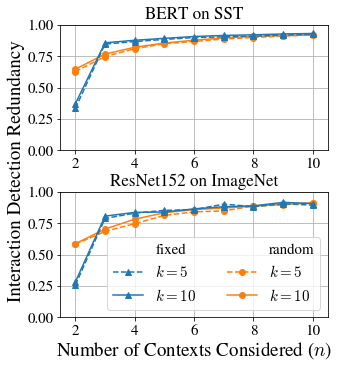

In [6]:
fig = plt.figure(figsize=(5.3,5.55))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


bert_plot_dict = get_plots(ax1, results["bert"])
resnet_plot_dict = get_plots(ax2, results["resnet"])


# Set common labels
ax.set_xlabel('Number of Contexts Considered ($n$)', size=19, labelpad=6)
ax.set_ylabel('Interaction Detection Redundancy', size=19, labelpad=16)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
empty_string_labels = ['']*5

ax1.set_ylim((0,1))
ax1.set_xlim((1.5,10.5))

ax2.set_ylim((0,1))
ax2.set_xlim((1.5,10.5))

ax1.set_title('BERT on SST', size=17)
ax2.set_title('ResNet152 on ImageNet', size=17)

categories = ["$k=5$", "$k=10$"]

p5, = plt.plot([0], marker='None',
           linestyle='None', label='dummy-tophead')

pd = resnet_plot_dict
ks = list(pd.keys())

leg = ax2.legend([p5, pd[ks[1]]["k5"], pd[ks[1]]["k10"],p5, pd[ks[0]]["k5"], pd[ks[0]]["k10"]], 
              [ legend_map[ks[1]] ] + categories + [legend_map[ks[0]]] + categories,
              loc=4, ncol=2, fontsize=15) # Two columns, vertical group labels

ax1.grid()
ax2.grid()

fig.tight_layout()
fig.subplots_adjust(hspace=0.33)

if save_plot:
    plt.savefig(plot_path, bbox_inches = "tight")

plt.show()